In [45]:
import author
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import sys
sys.path.insert(0, "/Users/jin/Programming/Machine_Learning/All-about-Market/trading/Jeong/machine_trade/code")
import eval_model
engine = author.processed_engine

2015년부터 5년간 비트코인의 가격과 연관된 정보들을 가져온다.

gap은 그날의 (고가 - 종가) / 시초가 로 변동성을 확인 하기 위한 지표이다.</br>
나머지 지표들은 말 그대로를 의미한다.

In [46]:
df = pd.read_sql("SELECT * FROM BTCUSD_1d",engine) #로컬 db에서 테이블 가져옴
df.set_index(df.columns[0], inplace=True)
df

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Moment,Pct
time,,,,,,,,,,,
2015-02-28,254.263,0.021,58.802,0.634,2.738,240.599,0.733,12.614,17.051,0.916,0.171
2015-03-01,260.202,0.064,61.534,1.301,3.969,240.808,1.271,43.719,25.940,0.930,2.336
2015-03-02,275.670,0.070,67.566,2.265,6.123,241.435,1.738,39.459,30.447,0.965,5.945
2015-03-03,281.702,0.066,69.571,3.456,8.221,242.400,1.773,25.331,28.741,0.980,2.188
2015-03-04,273.092,0.060,63.536,4.582,9.085,243.084,1.264,9.304,22.262,0.964,-3.056
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-03,46453.566,0.037,62.304,1435.036,1601.875,27629.223,0.797,11.046,9.406,71.145,1.275
2022-04-04,46622.676,0.034,62.867,1464.320,1581.457,27643.927,1.037,19.428,12.747,71.793,0.364
2022-04-05,45555.992,0.034,57.075,1463.925,1462.346,27657.210,0.953,0.180,8.558,72.156,-2.288


In [47]:
df.describe()

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Moment,Pct
count,2596.000000,2596.000000,2596.000000,2596.000000,2596.000000,2596.000000,2596.000000,2596.00000,2596.000000,2596.000000,2596.000000
mean,12571.830403,0.048304,54.390020,114.007460,116.032718,8078.249313,1.012399,12.46857,12.478756,19.936354,0.272779
std,16706.330633,0.044152,14.126366,925.640314,974.755951,7834.290130,0.264918,10.91075,5.197821,25.844302,3.839247
min,210.495000,0.003000,9.920000,-4438.999000,-5053.274000,240.599000,0.323000,0.00000,2.191000,0.776000,-37.170000
25%,772.384250,0.020000,44.267750,-58.906250,-58.370250,491.658750,0.856000,4.70750,8.701750,1.719750,-1.241000
50%,6734.095500,0.037000,53.685500,7.356000,8.061000,8361.347000,0.971500,9.48800,11.725500,10.994000,0.209500
75%,11323.249250,0.060000,63.796750,229.793500,232.024250,9824.798750,1.118000,16.98450,15.411250,17.754750,1.801750
max,67566.828000,0.631000,94.302000,4517.103000,5273.809000,27682.051000,3.120000,94.87100,38.352000,100.547000,25.247000


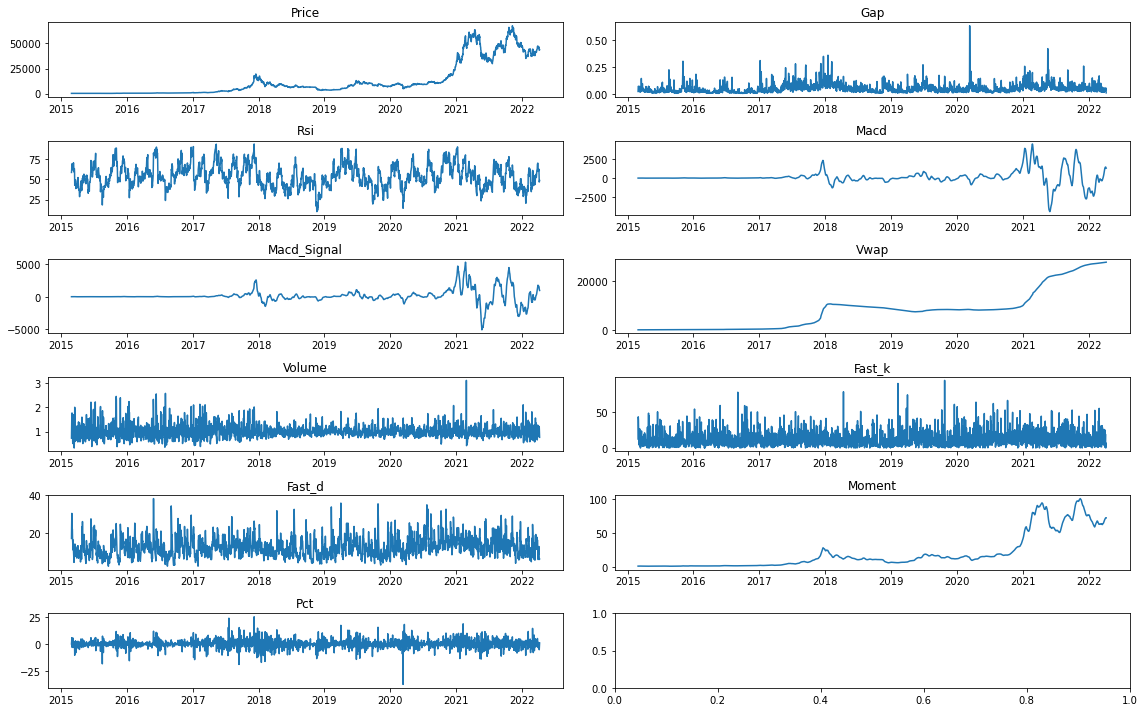

In [48]:
get_rows = lambda x: x // 2 if x % 2 == 0 else x // 2 +1 #행의 수를 결정한다.
rows = get_rows(len(df.columns))
fig, axes = plt.subplots(rows, 2, figsize=(16,10))
for i, c in enumerate(df.columns, start=1):
        plt.subplot(len(df.columns) // 2 + 1,2,i)
        plt.plot(df[c])
        plt.title(c)
plt.tight_layout()

volume은 시간이 지남에 따라 상승하는 경향이 보이므로 이동평균을 통해 나눠준 값을 사용한다.</br>
거래량 = (거래량 / 지난 7일간의 이동 평균 거래량) 평균적인 거래량에 비해 얼마나 더 많이 거래가 발생했는지 확인 가능하다.</br>
가격 역시 시간이 지남에 따라 자연히 증가하므로 전일 대비 증감률을 사용한다.
 <br>위의 그래프는 모두 전처리를 진행한 이후의 결과이다.

이렇게 데이터를 변형해 줌으로써 모델은 가격이 시간이 지남에 따라 자연히 증가하는 것이 아니라 학습 할 수 있다. </br>

Volume과 Pct를 보면 동일하게 거래량과 가격에 관한 지표를 나타내지만, 선형성이 사라진 것을 확인 할 수 있다. </br>
이제 모델은 무작정 시간이 지남에 따라 값이 증가한다고 예측하지 못한다.

<AxesSubplot:>

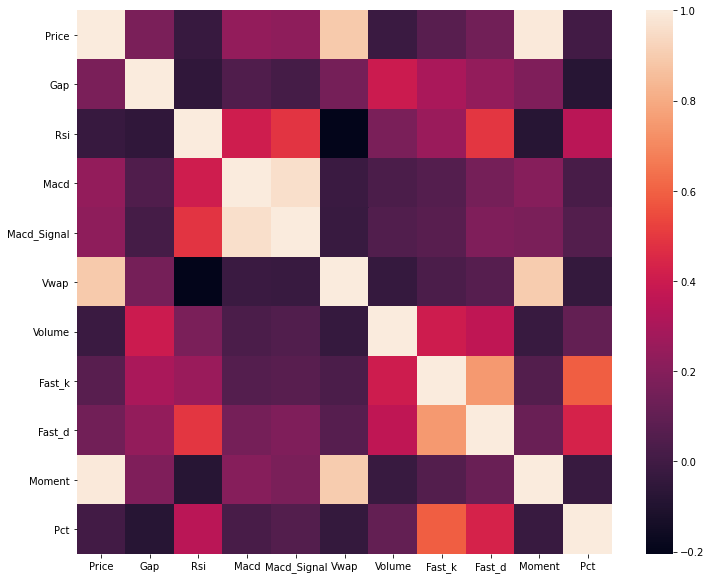

In [49]:
corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr)

In [50]:
corr[corr.abs() > 0.3]

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Moment,Pct
Price,1.000000,NaN,NaN,NaN,NaN,0.892480,NaN,NaN,NaN,0.995045,NaN
Gap,NaN,1.000000,NaN,NaN,NaN,NaN,0.400349,NaN,NaN,NaN,NaN
Rsi,NaN,NaN,1.000000,0.410113,0.491506,NaN,NaN,NaN,0.493830,NaN,0.348297
Macd,NaN,NaN,0.410113,1.000000,0.960934,NaN,NaN,NaN,NaN,NaN,NaN
Macd_Signal,NaN,NaN,0.491506,0.960934,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
Vwap,0.892480,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.900076,NaN
Volume,NaN,0.400349,NaN,NaN,NaN,NaN,1.000000,0.403095,0.363520,NaN,NaN
Fast_k,NaN,NaN,NaN,NaN,NaN,NaN,0.403095,1.000000,0.746825,NaN,0.592396
Fast_d,NaN,NaN,0.493830,NaN,NaN,NaN,0.363520,0.746825,1.000000,NaN,0.430889
Moment,0.995045,NaN,NaN,NaN,NaN,0.900076,NaN,NaN,NaN,1.000000,NaN


pct는 Rsi, Fask_k와 깊은 상관성을 보인다.</br>
price는 vwap와 관련이 깊어 보인다. 

RSI와 가격 증감률 간의 상관 관계를 나타내보면 다음과 같다. </br>
어느 정도의 양의 상관 관계를 갖는 것이 보인다.

In [51]:
def plot_corr(x, y, x_name = 'X_feature', y_name = 'y_feature'):
    plt.figure(figsize=(10,10))
    x = (x - x.min()) / (x.max() - x.min())
    y = (y - y.min()) / (y.max() - y.min())
    plt.scatter(x=x, y=y)
    plt.xlabel(x_name)
    plt.ylabel(y_name)

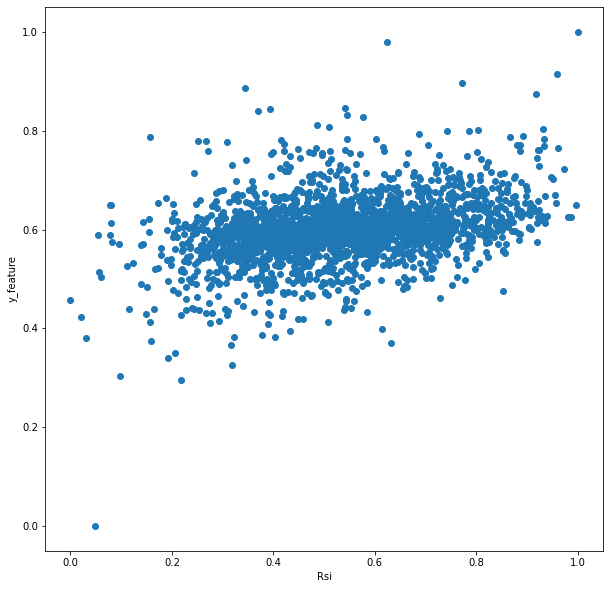

In [52]:
plot_corr(x=df['Rsi'], y=df['Pct'], x_name="Rsi")

VWAP와 가격의 상관 관계
* 강한 양의 상관 관계를 띄지만 파악이 불가한 부분이 존재한다.

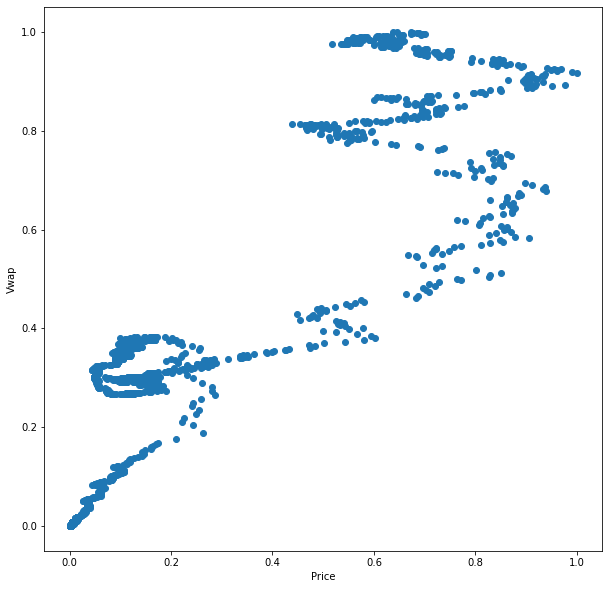

In [53]:
plot_corr(x=df['Price'], y=df['Vwap'], x_name="Price", y_name="Vwap")

#### MACD와 가격 증감률 간의 관계를 살펴보자.

MACD는 이평선의 수렴과 발산을 통해 과매수, 과매도를 보여주는 지표이다. 일반적으로 시그널선의 아래에 위치하면 과매도, 시그널 선의 위편에 위치하면 과매수 상태로 여긴다.


In [54]:
def get_cross(graph1, graph2):
    """ 특정한 그래프 2개를 입력받고 
    그래프가 교차되는 지점을 구해줍니다"""
    gap = graph1 - graph2
    buy_sign = []
    sell_sign = []
    for i, g in enumerate(gap.values[1:], start=1):
        if g * gap[i - 1] < 0:
            if g > 0: #차이가 양으로 전환되면 과매수이므로 매도 시그널이다.
                buy_sign.append(gap.index[i]) 
            else:
                sell_sign.append(gap.index[i])
    return buy_sign, sell_sign

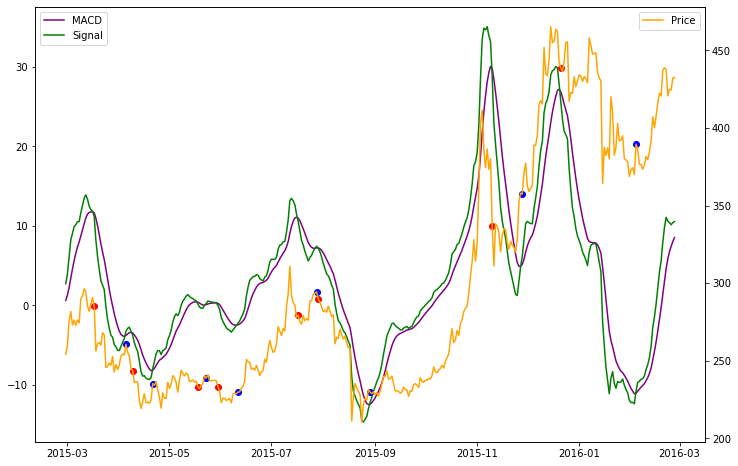

In [55]:
YEAR = 365
fig,ax1 = plt.subplots(figsize=(12,8))
macd_year, signal_year = df['Macd'].iloc[:YEAR], df['Macd_Signal'].iloc[:YEAR]
buy_point, sell_point = get_cross(macd_year, signal_year)
price = df['Price'].iloc[:YEAR]

ax1.plot(macd_year, label='MACD', color='purple')
ax1.plot(signal_year, label='Signal', color='green')
plt.legend(loc="upper left")


ax2 = ax1.twinx()
ax2.plot(price[:365],color='orange',label='Price')
ax2.scatter(buy_point, price.loc[buy_point], marker='o', color='red')
ax2.scatter(sell_point, price.loc[sell_point], marker='o', color='blue')

plt.legend(loc="upper right")

* MACD는 이동평균이라는 정보에 걸맞게 가격의 변동을 원만한 기울기로 추종하고 있다는 것을 확인 할 수 있다. </br>
* Signal과 교차되는 전략을 생각해보면 훌륭하게 들어 맞는다고 볼 수는 없을 것 같다. (빨강: 매수, 파랑: 매도)</br>


* 피쳐의 관점에선 MACD와 MACD 시그널은 실상 같은 움직임을 보이므로</br>
둘중 하나의 피쳐만 사용하는 쪽이 더 나을 듯 하다. </br>
아니면 시그널과 MACD의 격차만을 피쳐로 사용하는 것도 괜찮아 보인다.

#### 스토캐스틱 지표의 상관관계

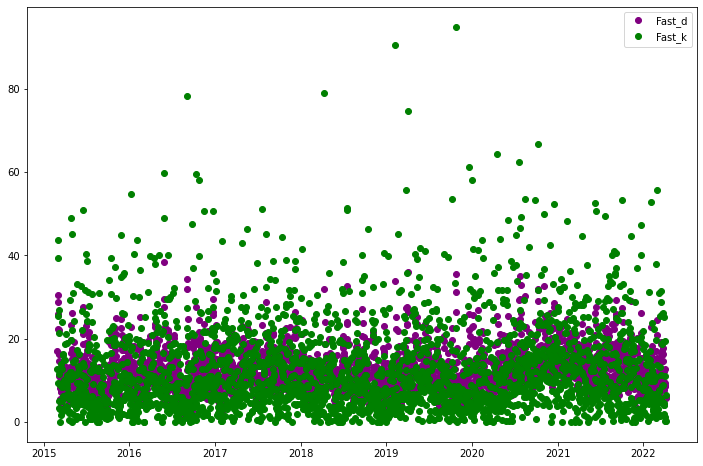

In [56]:
plt.figure(figsize=(12,8))
plt.plot(df['Fast_d'], label='Fast_d', color='purple',linestyle='None',marker='o')
plt.plot(df['Fast_k'], label='Fast_k', color='green',linestyle='None',marker='o')
plt.legend()

Fast_d는 Fast_k를 또 다시 이동평균을 내 활용한 지표이다 보니 값이 전반적으로 안정적이고 극렬하게 튀는 현상이 덜하다.</br>
Fast_k가 가격 증감률과의 상관관계도 더 높지만, 과하게 상태 변화를 받아들이는 값이라는 점에서 </br>
Fast_k보다 Fast_d를 사용하는 쪽이 유리해 보인다.</br>
Fast_k, Fast_d는 상관 계수가 0.7을 넘어가기에 하나만 사용한다.

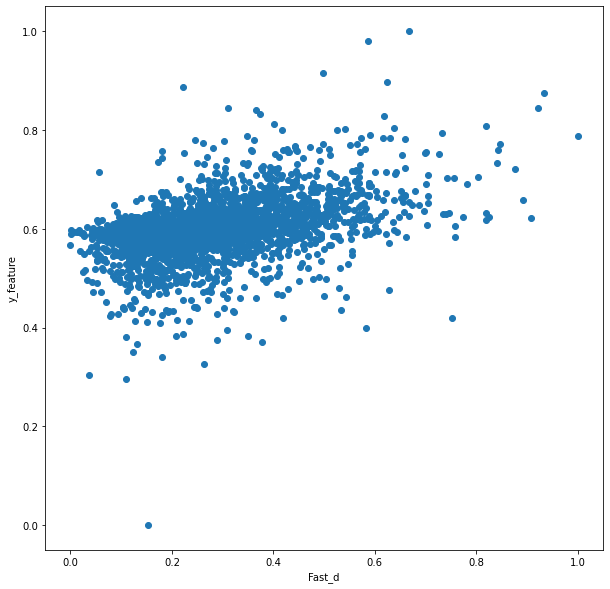

In [15]:
plot_corr(x=df['Fast_d'], y=df['Pct'],x_name="Fast_d")

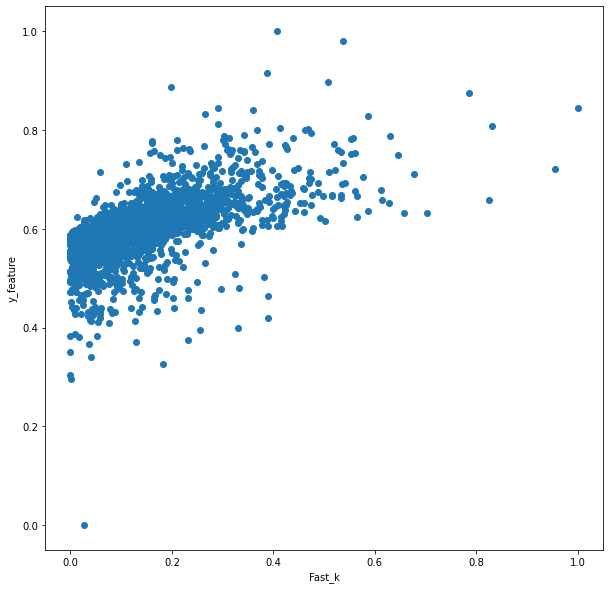

In [57]:
plot_corr(x=df['Fast_k'],y=df['Pct'],x_name="Fast_k")

#### 피쳐 선택
다음과 같은 피쳐를 제외하고 모델을 학습 시키기로 했다.
* Gap: 대신 가격 증감률을 사용하기로 했다.
* Macd, Macd_Signal: 대신 시그널 - MACD를 사용한다.
* Fast_k: 대신 Fast_d를 사용한다.

In [65]:
macd_gap = df['Macd_Signal'] - df['Macd']
new_df = df.drop(["Macd","Fast_k","Volume","Gap"], axis=1)
new_df["Macd_Gap"] = macd_gap
new_df

,Price,Rsi,Macd_Signal,Vwap,Fast_d,Moment,Pct,Macd_Gap
time,,,,,,,,
2015-02-28,254.263,58.802,2.738,240.599,17.051,0.916,0.171,2.104
2015-03-01,260.202,61.534,3.969,240.808,25.940,0.930,2.336,2.668
2015-03-02,275.670,67.566,6.123,241.435,30.447,0.965,5.945,3.858
2015-03-03,281.702,69.571,8.221,242.400,28.741,0.980,2.188,4.765
2015-03-04,273.092,63.536,9.085,243.084,22.262,0.964,-3.056,4.503
...,...,...,...,...,...,...,...,...
2022-04-03,46453.566,62.304,1601.875,27629.223,9.406,71.145,1.275,166.839
2022-04-04,46622.676,62.867,1581.457,27643.927,12.747,71.793,0.364,117.137
2022-04-05,45555.992,57.075,1462.346,27657.210,8.558,72.156,-2.288,-1.579


#### 모멘텀 지표
* 추가적으로 특정 주기별 비트코인의 기하 평균 수익률을 기록하는 모멘텀 지표를 추가해준다.
* 모멘텀 지표를 통해 추세를 확인 할 수 있다.

In [59]:
def get_profit(X):
    """수익률을 구해준다."""
    seed = [1]
    for i, v in enumerate(X[1:], start=1):
        seed.append(seed[i - 1] * (1 + v))
    return seed

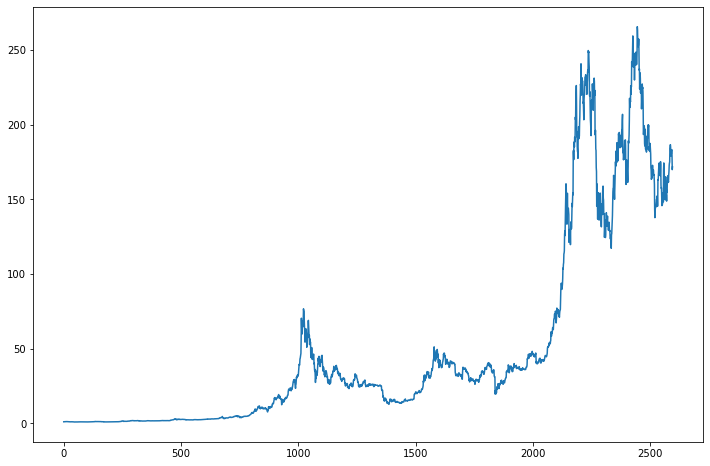

In [60]:
plt.figure(figsize=(12,8))
plt.plot(get_profit(new_df['Pct'] / 100))

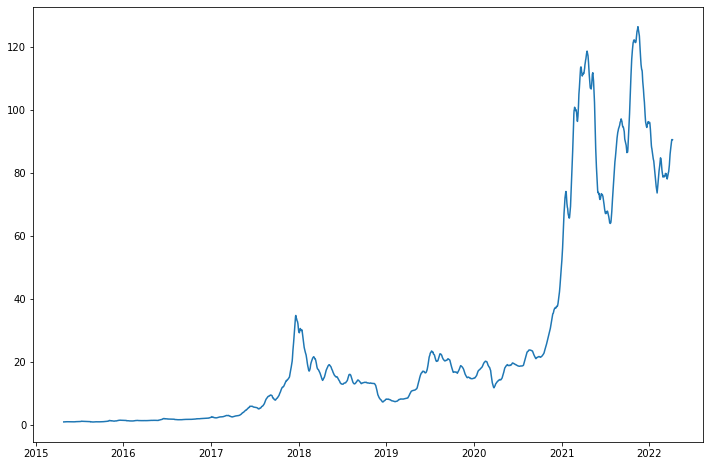

In [66]:
#수익 곡선을 그려보자 비트코인 그래프와 흡사하게 그려진다.
#모멘텀 팩터 만들기
profit = pd.Series(index=new_df.index, data=get_profit(new_df['Pct'] / 100)) #profit은 실제 내 수익률을 보여준다.
w2 = profit.rolling(14).apply(lambda x: x.prod() ** (1.0 / 14)) #2주 간의 기하 평균 수익률
m1 = profit / profit.rolling(30).apply(lambda x: x.prod() ** (1.0 / 30)) #1달 간의 기하 평균 수익률
m2 = profit / profit.rolling(60).apply(lambda x: x.prod() ** (1.0 / 60)) #2달 간의 기하 평균 수익률
momentum = (w2 * 0.5 + m1 * 0.3 + m2 * 0.2).dropna()
plt.figure(figsize=(12, 8))
plt.plot(momentum)

* 모멘텀 지표는 실제 수익률 그래프와 비교했을 때 평균을 활용하기에 훨씬 부드럽고 </br>
전반적인 추세 파악에 유용하다.

#### 이상치 확인 해보기
* iqr 범위를 벗어나는 데이터가 몇개 있는지 확인해보자. 
* gap, vwap, macd가 특히 심하다.


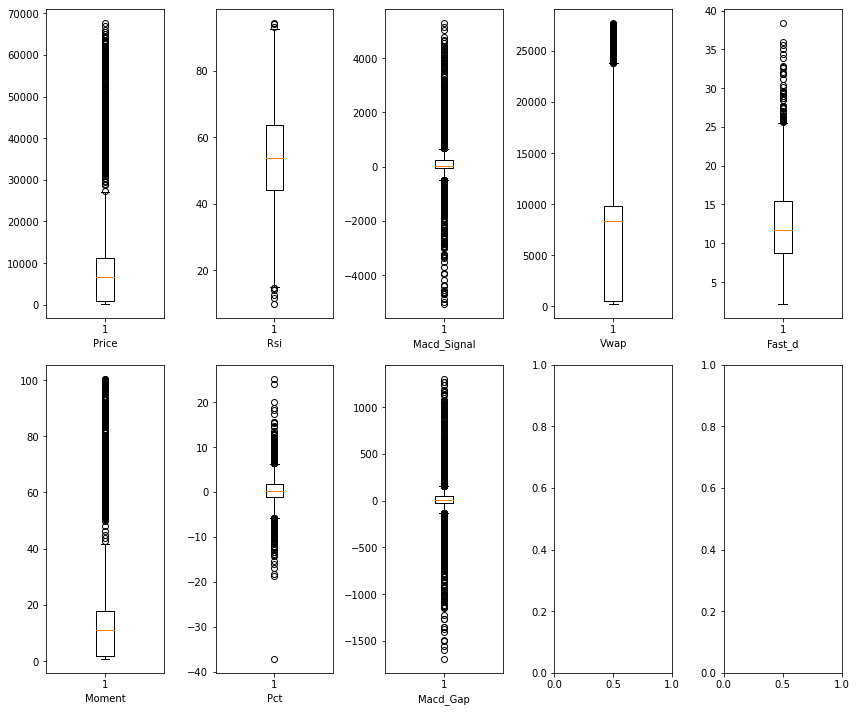

In [67]:
fig,axes = plt.subplots(2,5,figsize=(12,10))
for i, c in enumerate(new_df.columns,start=1):
    plt.subplot(2,5,i)
    plt.boxplot(new_df[c])
    plt.xlabel(c)
plt.tight_layout()

In [68]:
from collections import defaultdict
def get_outliers(df):
    """ 
        iqr 범위를 벗어나는 아웃 라이어들의 인덱스를 반환한다.
    """
    q_1 = df.apply(lambda x: np.quantile(x, 0.25))
    q_3 = df.apply(lambda x: np.quantile(x, 0.75))
    iqr = q_3 - q_1
    min_p = q_1 - 1.5 * iqr
    max_p = q_3 + 1.5 * iqr
    outliers = np.where((df < min_p) | (df > max_p))
    row, col = outliers
    outliers_loc = defaultdict(list)
    for r,c in zip(row,col):
        outliers_loc[df.columns[c]].append(r)
    return outliers_loc


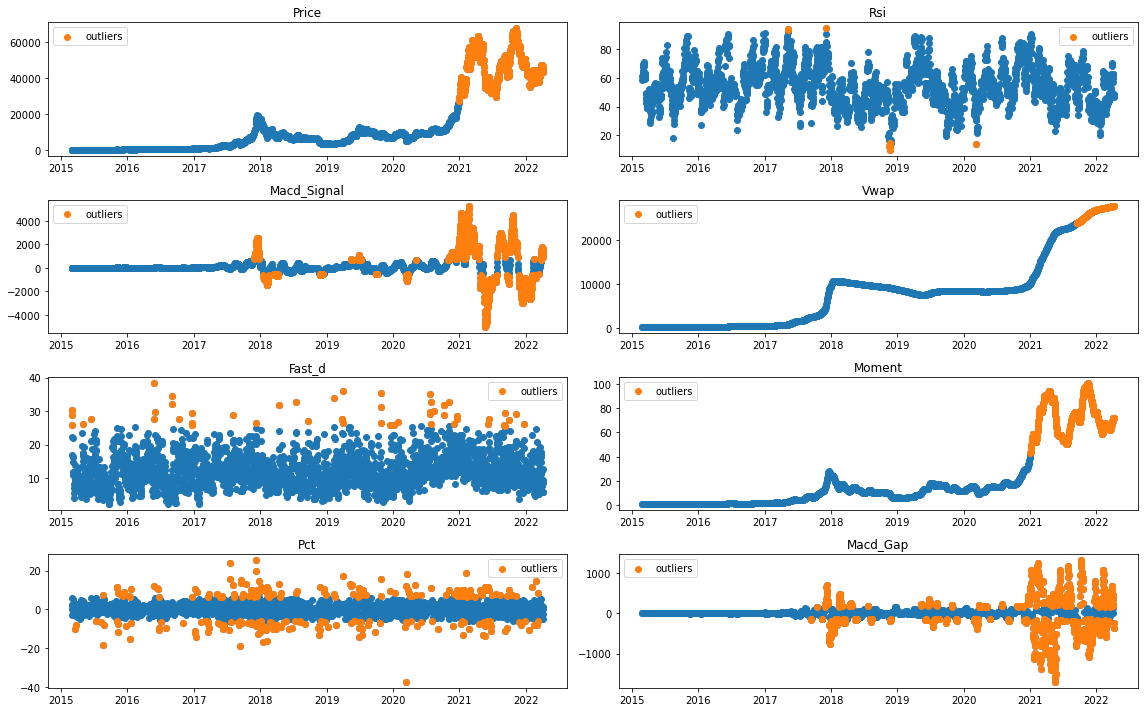

In [69]:
def draw_outlier(outliers_cols, df):
    """ 아웃 라이어들을 피쳐 별로 전부 그려 줍니다"""
    rows = get_rows(len(df.columns))
    fig, axes = plt.subplots(rows, 2, figsize=(16,10))
    for i, c in enumerate(df.columns,start=1):
        index = df[c].index
        plt.subplot(rows,2,i)
        plt.title(c)
        plt.scatter(x=index, y=df[c])
        plt.scatter(x=df[c].iloc[outliers_cols[c]].index, y=df[c].iloc[outliers_cols[c]],label='outliers')
        plt.legend()
    plt.tight_layout()

outliers_cols = get_outliers(new_df)
draw_outlier(outliers_cols, new_df)

피쳐별로 아웃라이어를 모조리 제거해 주기에는 문제가 있다. </br>
RSI에서 잡힌 아웃라이어 정도만 제거해준다.

In [70]:
for k, v in outliers_cols.items():
    print(f"{k}: {len(v)}")

Fast_d: 51
Pct: 269
Rsi: 9
Macd_Gap: 652
Macd_Signal: 585
Price: 465
Moment: 460
Vwap: 203


<AxesSubplot:>

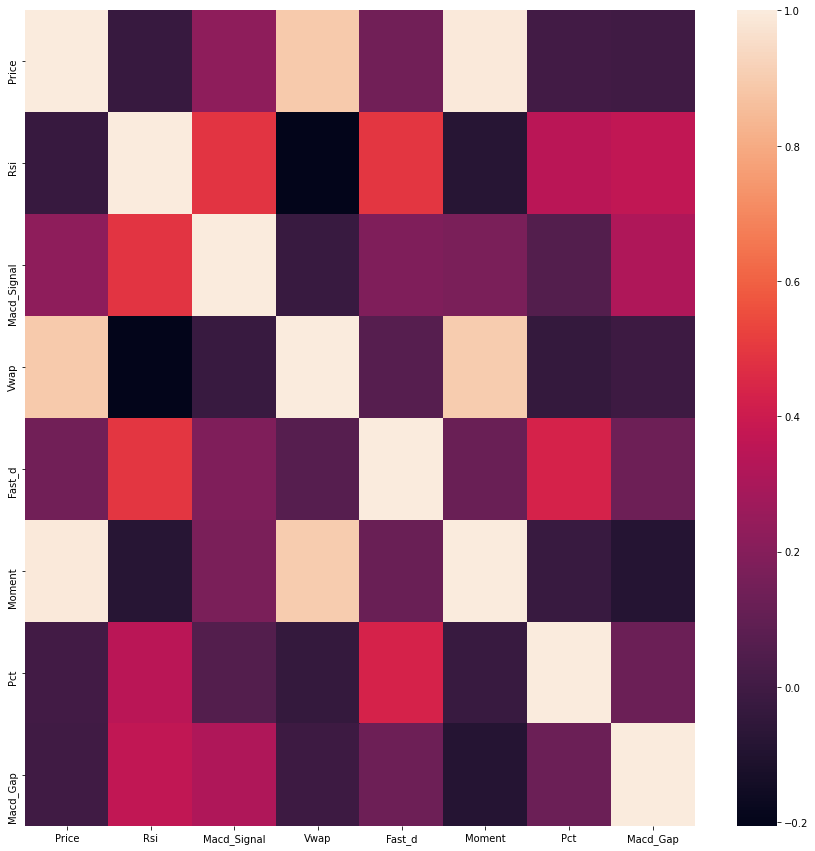

In [71]:
corr = new_df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr)

모멘트 팩터는 큰 연관성은 없어 보이지만, 전반적인 수익률 곡선의 추세를 보여주기에 사용했다.</br>
기존에 존재하는 듀얼 모멘텀 전략 등에서의 아이디어를 활용할 수는 없을까? 라는 가정에서 출발했다.</br>
모멘트 팩터는 실상 조금 완만한 가격 데이터라 해도 과언이 아니다.

모델을 생성하고 비교해보자.

In [103]:
ridge_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=3, include_bias=False)),
    ('min_max', MinMaxScaler()),
    ('regulator', Ridge(alpha=10,solver="cholesky", random_state=42, fit_intercept=True, max_iter=2000))
])

lasso_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=3, include_bias=True)),
    ('min_max', MinMaxScaler()),
    ('regulator', Lasso(alpha=10, random_state=42, fit_intercept=True, max_iter=2000))
])

elastic_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=3, include_bias=True)),
    ('min_max', MinMaxScaler()),
    ('regulator', ElasticNet(alpha=10, random_state=42, fit_intercept=True, max_iter=2000, l1_ratio=0.8))
])

rf_model = Pipeline([
    ('min_max',MinMaxScaler()),
    ('machine',RandomForestRegressor(bootstrap=True, random_state=42, oob_score=True, max_depth=2000))
])

In [97]:
def create_train_data(df):
    """ 트레이닝 데이터를 생성한다. 
        다음날 데이터를 예측 해야 하므로 한 칸씩 미뤄주고 댕겨준다.
    """
    X = df.drop(['Price'], axis=1).iloc[1:]
    y = df['Price'].iloc[:-1]
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)
    return train_X, test_X, train_y, test_y

In [101]:
train_X, test_X, train_y, test_y = create_train_data(new_df)
ridge_model.fit(train_X, train_y)
lasso_model.fit(train_X, train_y)
elastic_model.fit(train_X, train_y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=1)),
                ('min_max', MinMaxScaler()),
                ('regulator',
                 ElasticNet(alpha=10, l1_ratio=0.8, max_iter=2000,
                            random_state=42))])

In [88]:
def plot_coef(coef, index, intercept=False):
    if intercept:
        index = index.insert(0, "Intercept")
    coef_df = pd.DataFrame(data=coef,index=index,columns=["Coef"])
    coef_df.plot.bar()


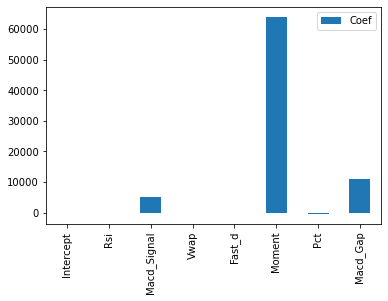

In [102]:
plot_coef(lasso_model['regulator'].coef_, train_X.columns, True)

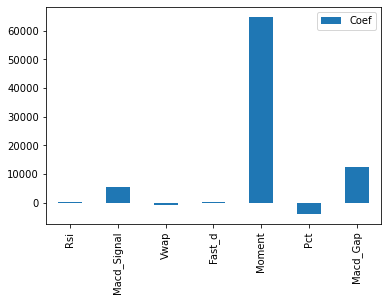

In [90]:
plot_coef(ridge_model['regulator'].coef_, train_X.columns)

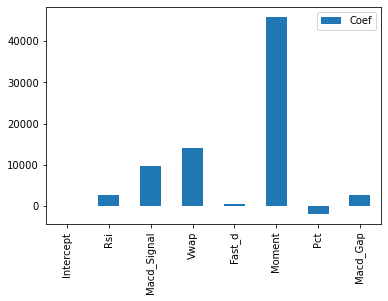

In [92]:
plot_coef(elastic_model['regulator'].coef_, train_X.columns, True)

In [104]:
def find_best_alpha(train_X, train_y, test_X, test_y, model):
    """파라미터 값을 변경해가며 알파 값을 바꿔본다."""
    best_alpha = 1
    best_mse = float('inf')
    print(model['regulator'])
    for i in [1000,300,100,30,10,1,0.1,0.03]:
        model.set_params(regulator__alpha=i)
        model.fit(train_X, train_y)
        pred = model.predict(test_X)
        mse = ((test_y - pred) ** 2).mean()
        if best_mse > mse:
            best_mse = mse
            best_alpha = i
        print(f'mse: {mse}, alpha: {i}')
    return best_alpha
    
r_alpha = find_best_alpha(train_X, train_y, test_X, test_y, ridge_model)
ridge_model.set_params(regulator__alpha=r_alpha)
ridge_model.fit(train_X, train_y)

l_alpha = find_best_alpha(train_X, train_y, test_X, test_y, lasso_model)
lasso_model.set_params(regulator__alpha=l_alpha)
lasso_model.fit(train_X, train_y)

e_alpha = find_best_alpha(train_X, train_y, test_X, test_y, elastic_model)
elastic_model.set_params(regulator__alpha=e_alpha)
elastic_model.fit(train_X, train_y)



Ridge(alpha=10, max_iter=2000, random_state=42, solver='cholesky')
mse: 49449443.224935606, alpha: 1000
mse: 14462155.30392933, alpha: 300
mse: 7431645.364264326, alpha: 100
mse: 4097255.9797314913, alpha: 30
mse: 1822025.5025722543, alpha: 10
mse: 275772.4962487631, alpha: 1
mse: 105427.91410501719, alpha: 0.1
mse: 92241.66631681699, alpha: 0.03
Lasso(alpha=10, max_iter=2000, random_state=42)
mse: 16966388.41134244, alpha: 1000
mse: 3725625.3005436882, alpha: 300
mse: 1259490.106810209, alpha: 100
mse: 509506.2707141794, alpha: 30
mse: 205718.5474752255, alpha: 10
mse: 118659.71279226175, alpha: 1
mse: 93340.82580965276, alpha: 0.1


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63882483.06530617, tolerance: 51050201.37425165
  model = cd_fast.enet_coordinate_descent(


mse: 90721.40224490725, alpha: 0.03


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63882483.06530617, tolerance: 51050201.37425165
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=10, l1_ratio=0.8, max_iter=2000, random_state=42)
mse: 271667277.6472073, alpha: 1000
mse: 266760731.63816017, alpha: 300
mse: 253353095.55100772, alpha: 100
mse: 213672196.4542879, alpha: 30
mse: 141098596.69153777, alpha: 10
mse: 17183520.613403544, alpha: 1
mse: 4582576.37549806, alpha: 0.1
mse: 1958873.5783638943, alpha: 0.03


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('min_max', MinMaxScaler()),
                ('regulator',
                 ElasticNet(alpha=0.03, l1_ratio=0.8, max_iter=2000,
                            random_state=42))])

In [105]:
def visualize(pred,target,name):
    plt.figure(figsize=(20,12))
    index = np.arange(len(target))
    plt.scatter(index, target,label='target')
    plt.scatter(index, pred,label='model')
    mse = np.mean((target - pred) ** 2)
    plt.suptitle(f'{name}',fontsize=20)
    plt.title(f'MSE is {mse:.3f}')
    plt.legend()

In [106]:
r_pred = ridge_model.predict(test_X)
l_pred = lasso_model.predict(test_X)
e_pred = elastic_model.predict(test_X)

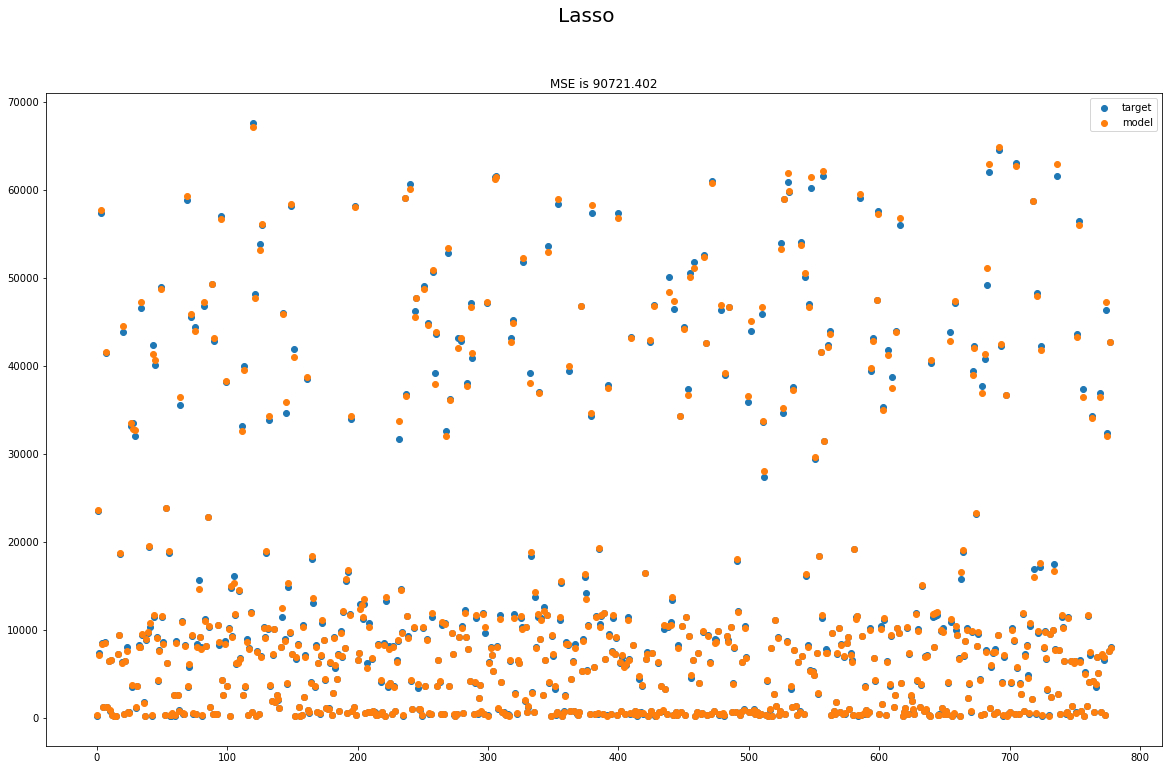

In [107]:
visualize(l_pred, test_y, "Lasso")


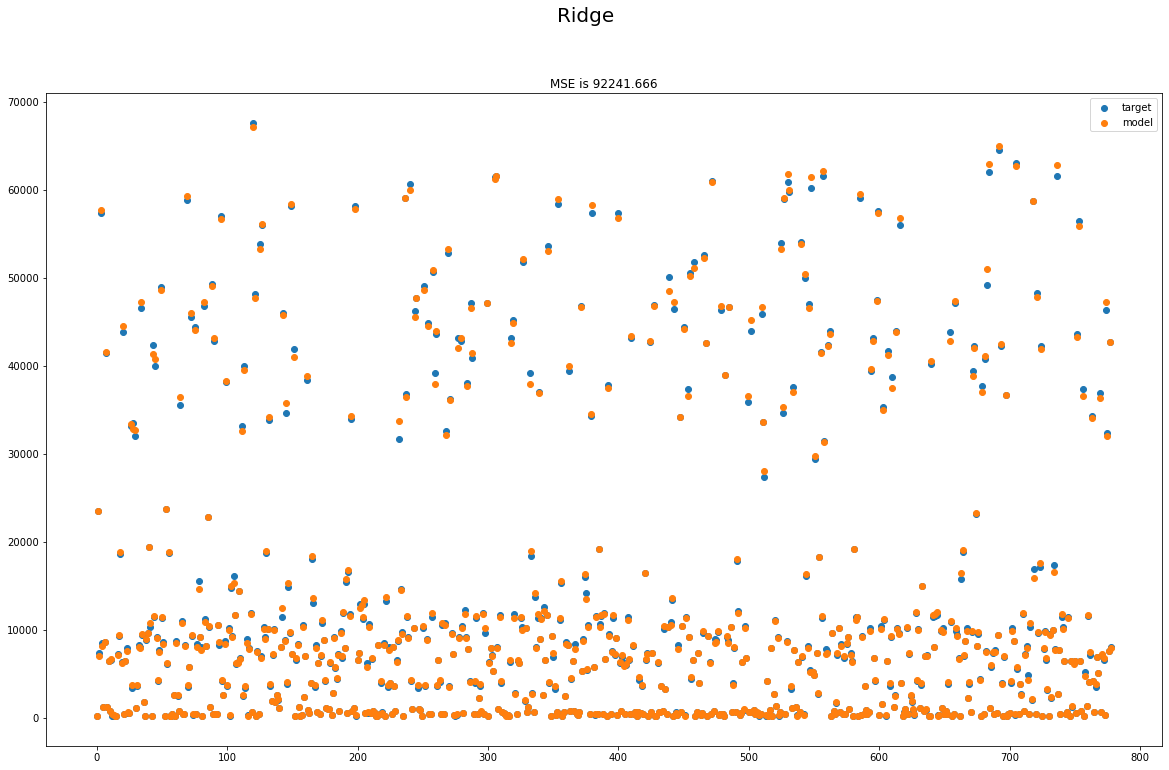

In [108]:
visualize(r_pred, test_y, "Ridge")


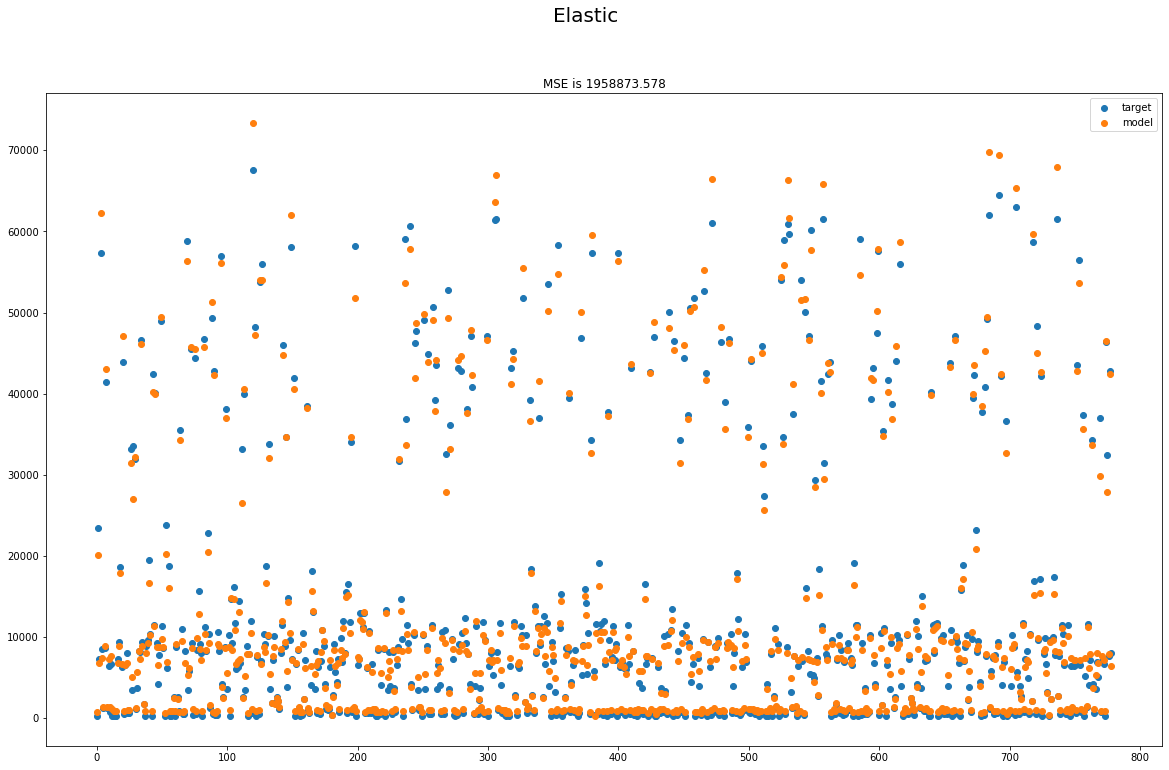

In [109]:
visualize(e_pred, test_y, "Elastic")

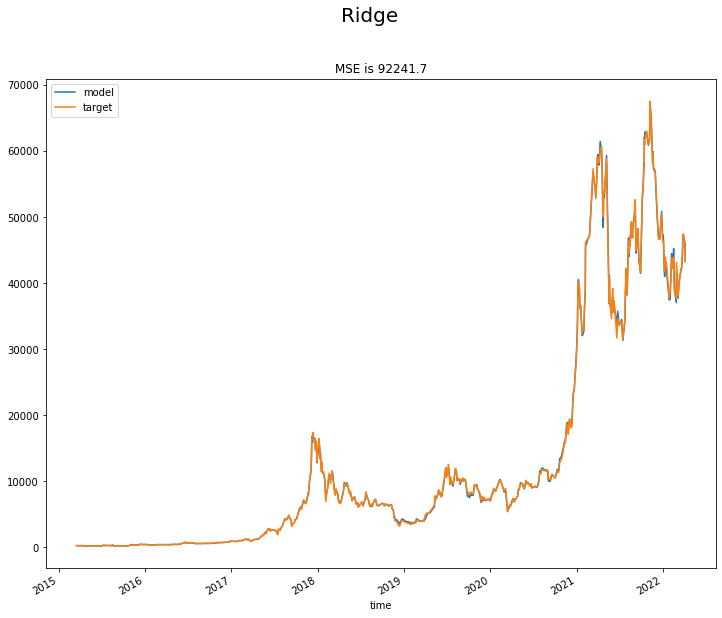

In [110]:
eval_model.visualize_plot(r_pred, test_y, "Ridge")


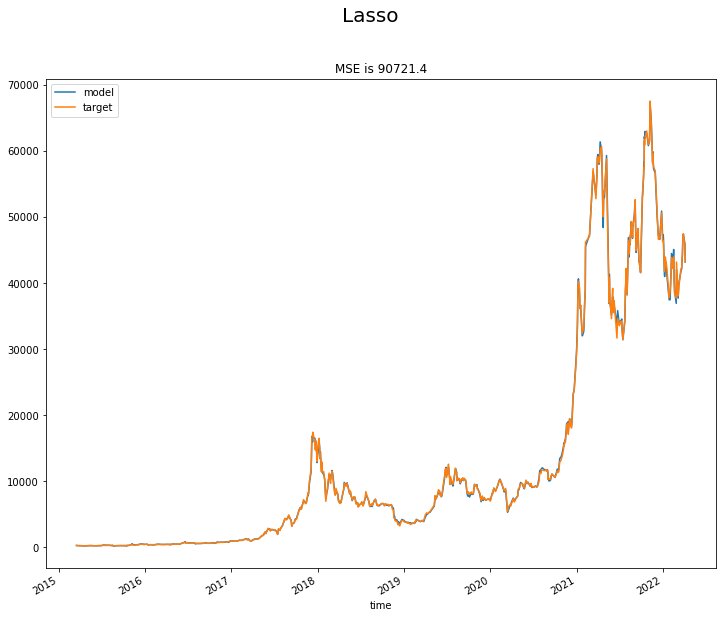

In [111]:
eval_model.visualize_plot(l_pred, test_y, "Lasso")

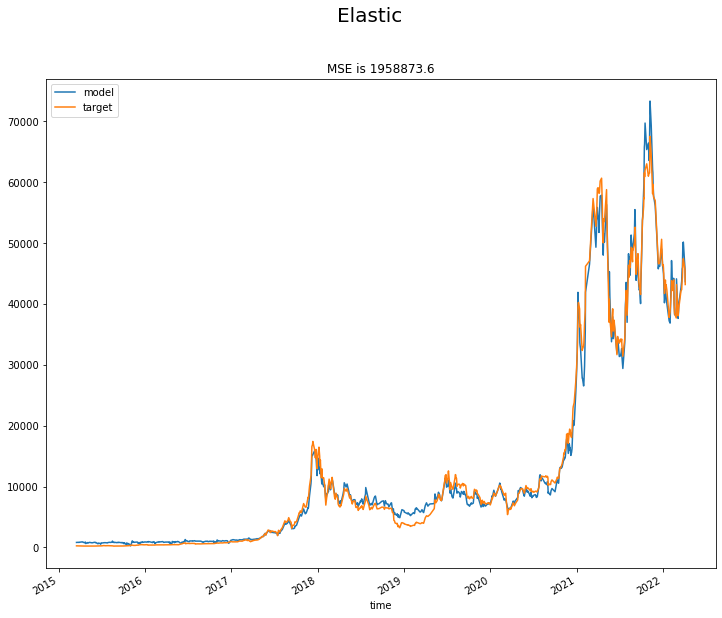

In [112]:
eval_model.visualize_plot(e_pred, test_y, "Elastic")


In [23]:
rf_model.fit(train_X, train_y)
rf_pred = rf_model.predict(test_X)

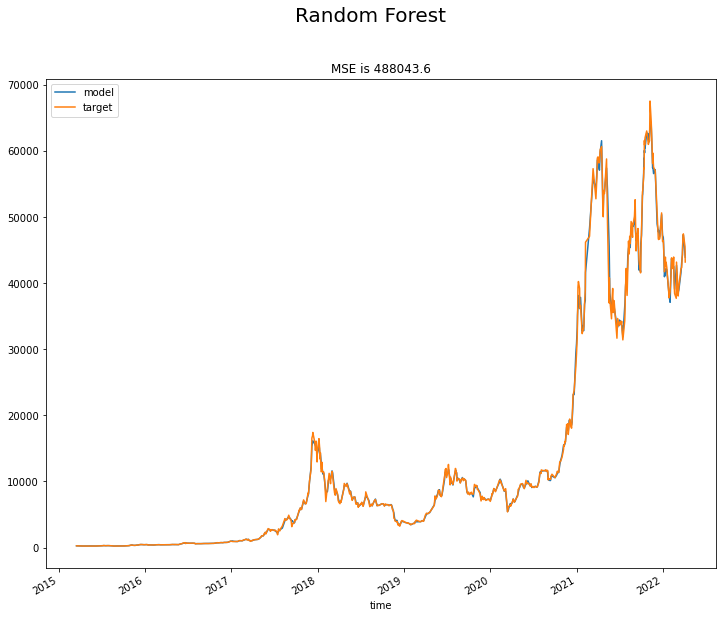

In [24]:
eval_model.visualize_plot(rf_pred, test_y, "Random Forest")

### 모델
* 모델의 성능은 충격적이게도 라쏘가 가장 괜찮은 성능을 보이고 있다. 
* 실상 모맨텀 팩터 하나에만 의지하며 예측을 진행하고 있다.

In [25]:
import joblib
joblib.dump(lasso_model, "Lasso_BTC_only.pkl")
joblib.dump(ridge_model, "Ridge_BTC_only.pkl")

['Ridge_BTC_only.pkl']

In [118]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
tscv = TimeSeriesSplit(n_splits=20)
train_X = df.drop(['Price'], axis=1).iloc[1:]
train_y = df['Price'].iloc[:-1]
cv_result = []
for m in [ridge_model, lasso_model, elastic_model]:
    result = []
    for i, (train_index, test_index) in enumerate(tscv.split(train_X)):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        model = m.fit(X_train, y_train)
        pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, pred)
        mse = np.sqrt(mean_squared_error(y_test, pred))
        score = r2_score(y_test, pred)
        result.append([mae, mse, score])
    cv_result.append(pd.DataFrame(data = result, columns=["mae","mse","score"]))

In [120]:
cv_result[0] #ridge

,mae,mse,score
0,6.532533,15.053444,0.869599
1,33.502982,39.660529,-0.111406
2,5.359985,9.439296,0.992387
3,9.875369,12.068430,0.928957
4,31.931477,44.578178,0.923405
5,873.838841,1249.540394,-2.921436
6,277.373999,409.502397,0.914039
7,4117.852615,7462.378292,-4.869138
8,243.989813,322.311387,0.902503
9,156.625453,186.301180,0.921587


In [121]:
cv_result[1] #lasso

,mae,mse,score
0,5.878195,8.329838,0.960071
1,17.639376,20.548557,0.701655
2,20.243756,33.979540,0.901348
3,18.660841,20.093078,0.803070
4,22.516519,31.092432,0.962738
5,155.756715,227.786053,0.869684
6,389.713589,574.637988,0.830731
7,1980.062434,2566.252548,0.305906
8,281.203341,369.730350,0.871705
9,177.287335,200.384424,0.909284


In [124]:
cv_result[2] #elastic

,mae,mse,score
0,11.309818,20.685720,0.753764
1,12.918208,15.485179,0.830571
2,45.822502,58.575642,0.706841
3,58.017885,62.954180,-0.933162
4,72.627506,97.229108,0.635623
5,840.208704,1273.574303,-3.073738
6,789.258482,986.305639,0.501332
7,11290.236855,13013.979295,-16.850074
8,966.873316,1341.387932,-0.688681
9,307.132095,408.625826,0.622767


In [125]:
for name, cv in zip(["Ridge","Lasso","Elastic"], cv_result):
    print(f"{name}:\n {cv.mean()}")

Ridge:
 mae       714.094728
mse      1047.900888
score       0.286376
dtype: float64
Lasso:
 mae      741.504030
mse      945.352976
score      0.744094
dtype: float64
Elastic:
 mae      2222.945516
mse      2758.016960
score      -1.411573
dtype: float64


In [123]:
for i,(tr,te) in enumerate(tscv.split(train_X)):
    if i == 7 or i == 16 or i == 17:
        print(train_X.iloc[te])

              Gap     Rsi     Macd  Macd_Signal       Vwap  Volume  Fast_k  \
time                                                                         
2017-11-21  0.075  66.307  436.663      513.528   3862.573   1.048  10.904   
2017-11-22  0.028  68.057  455.942      533.059   3897.504   0.909   6.293   
2017-11-23  0.028  63.849  469.785      525.153   3936.540   1.092   0.000   
2017-11-24  0.055  66.107  481.852      530.119   3983.154   1.288  10.954   
2017-11-25  0.073  70.986  499.646      570.825   4026.099   1.079  18.331   
...           ...     ...      ...          ...        ...     ...     ...   
2018-03-19  0.060  42.267 -411.105     -560.128  10482.593   1.112  10.927   
2018-03-20  0.079  45.235 -431.588     -513.522  10476.210   1.042  14.826   
2018-03-21  0.037  45.404 -439.249     -469.894  10470.901   0.999   3.017   
2018-03-22  0.063  43.565 -440.675     -446.377  10465.470   0.944   6.441   
2018-03-23  0.062  45.359 -434.701     -410.807  10459.345   1.0